# Preamble

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%matplotlib inline

In [3]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

import numpy as np
import pickle
from scipy.interpolate import interp1d
from scipy.integrate import odeint

import integrals as integ
import diff_eq_multi_2 as diff_eq
import physics as phys

# Load the standard solution.
a = pickle.load(open('../data/std_soln_He.p','rb'))

std_Tm = interp1d(a[0,:], a[1,:])
std_xH = interp1d(a[0,:], a[2,:])

# Choice of Parameters

In [4]:
m_m = 2e9
m_C = 1e8
f   = 1e-4
Q   = 1.2e-3

# Constraints on $Q_{d,\mathrm{eff}}$

In [5]:
def max_Q_d_eff(m_m, m_C, f, Q):
    
    g_em    = np.sqrt(4*np.pi*phys.alpha)
    mu_pC   = m_C*phys.mp/(m_C + phys.mp)
    f_ratio = 1. + phys.omega_baryon/(f*phys.omega_DM)
    
    max_SI             = 0.26*(m_C/1e9)**(3/8) * np.sqrt(np.sqrt(4*np.pi)/g_em)
    max_CMB            = 1e-3 * np.sqrt(m_C/1e9) * np.sqrt(m_m/1e9) * (1e9/(m_m + m_C))**0.25 * f_ratio**0.25
    max_tight_coupling = 0.08 * np.sqrt(Q) * np.sqrt(m_C/1e8) * (1e9/m_m)**0.25
    
    return np.min((max_SI, max_CMB, max_tight_coupling))

# Integration

In [8]:
rs_start = 5000
rs_vec = np.flipud(np.arange(10., 1.+rs_start, 1))

# Initial conditions are T_CMB - T_b, T_b - T_m, log(T_C), log(V_bm), log(V_cb), xe
init_cond = [1e-6, 1e-6, np.log(1e-6), np.log(1e-16), np.log(29e5/phys.c), 1.]

Q_d_eff = max_Q_d_eff(m_m, m_C, f, Q)

def to_integrate(rs, var):
    neutral_H = True
    neutral_He = True
    return diff_eq.DM_baryon_ODE(
        rs, var, 
        m_m, m_C, Q, Q_d_eff, neutral_H, neutral_He, f, True
    )


from scipy.integrate import solve_ivp

print('Starting the solver...')

soln = solve_ivp(
    to_integrate, [rs_vec[0], rs_vec[-1]], init_cond, 
    method='BDF', t_eval=rs_vec, rtol=0.3e-4,
)

print('Complete!')

rs_vec   = soln['t']
soln_vec = np.transpose(soln['y'])

Starting the solver...


../integrals.py:246: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(4*np.pi*n_eV_cubed*ele_squared/T_zeta)


Complete!


# Computing Rates

In [9]:
Delta_CMB_b_arr = soln_vec[:,0]
Delta_b_m_arr   = soln_vec[:,1]
xe_arr          = soln_vec[:,5]

V_bm_arr = np.exp(soln_vec[:,3])
V_mC_arr = np.exp(soln_vec[:,4]) 

T_b_arr = phys.TCMB(rs_vec) - Delta_CMB_b_arr
T_m_arr = T_b_arr - Delta_b_m_arr
T_C_arr = np.exp(soln_vec[:,2])
Delta_m_C_arr = T_m_arr - T_C_arr

# Compton Cooling Rate / Hubble Cooling

compton_cooling_rate = (
    xe_arr / (1 + xe_arr + phys.chi) * Delta_CMB_b_arr
    * 32 * phys.thomson_xsec * phys.stefboltz
    * phys.TCMB(rs_vec)**4 / (3 * phys.me) / (phys.hubble(rs_vec) * T_b_arr)
)

# e/p Energy Transfer Rate (per volume)

n_Q_i_ep = np.array([
    diff_eq.n_Q_i_dot_sum(
        m_m, m_C, Q, Q_d_eff, 
        Delta_CMB_b, Delta_b_m, Delta_m_C,
        V_bm, V_mC, xe, rs, False, False,
        f, neutrals_only=False
    ) for Delta_CMB_b, Delta_b_m, Delta_m_C, V_bm, V_mC, xe, rs in zip(
        Delta_CMB_b_arr, Delta_b_m_arr, Delta_m_C_arr, V_bm_arr, V_mC_arr, xe_arr, rs_vec
    )
]).flatten()

# H/He Energy Transfer Rate (per volume)

n_Q_i_HHe = np.array([
    diff_eq.n_Q_i_dot_sum(
        m_m, m_C, Q, Q_d_eff, 
        Delta_CMB_b, Delta_b_m, Delta_m_C,
        V_bm, V_mC, xe, rs, True, True,
        f, neutrals_only=True
    ) for Delta_CMB_b, Delta_b_m, Delta_m_C, V_bm, V_mC, xe, rs in zip(
        Delta_CMB_b_arr, Delta_b_m_arr, Delta_m_C_arr, V_bm_arr, V_mC_arr, xe_arr, rs_vec
    )
]).flatten()

# e/p Cooling Rate / Hubble Cooling

ep_cooling_rate = (
    (2./3.)*1./(phys.nH*rs_vec**3 * (1 + xe_arr + phys.chi))  * n_Q_i_ep / (phys.hubble(rs_vec) * T_b_arr)
)

# H/He Cooling Rate / Hubble Cooling

HHe_cooling_rate = (
    (2./3.)*1./(phys.nH*rs_vec**3 * (1 + xe_arr + phys.chi))  * n_Q_i_HHe / (phys.hubble(rs_vec) * T_b_arr)
)

# Where does Born approximation not hold?

born_break = Q/(T_b_arr/phys.mp)

rs_born_break = rs_vec[np.where(born_break > 1e7)][0]

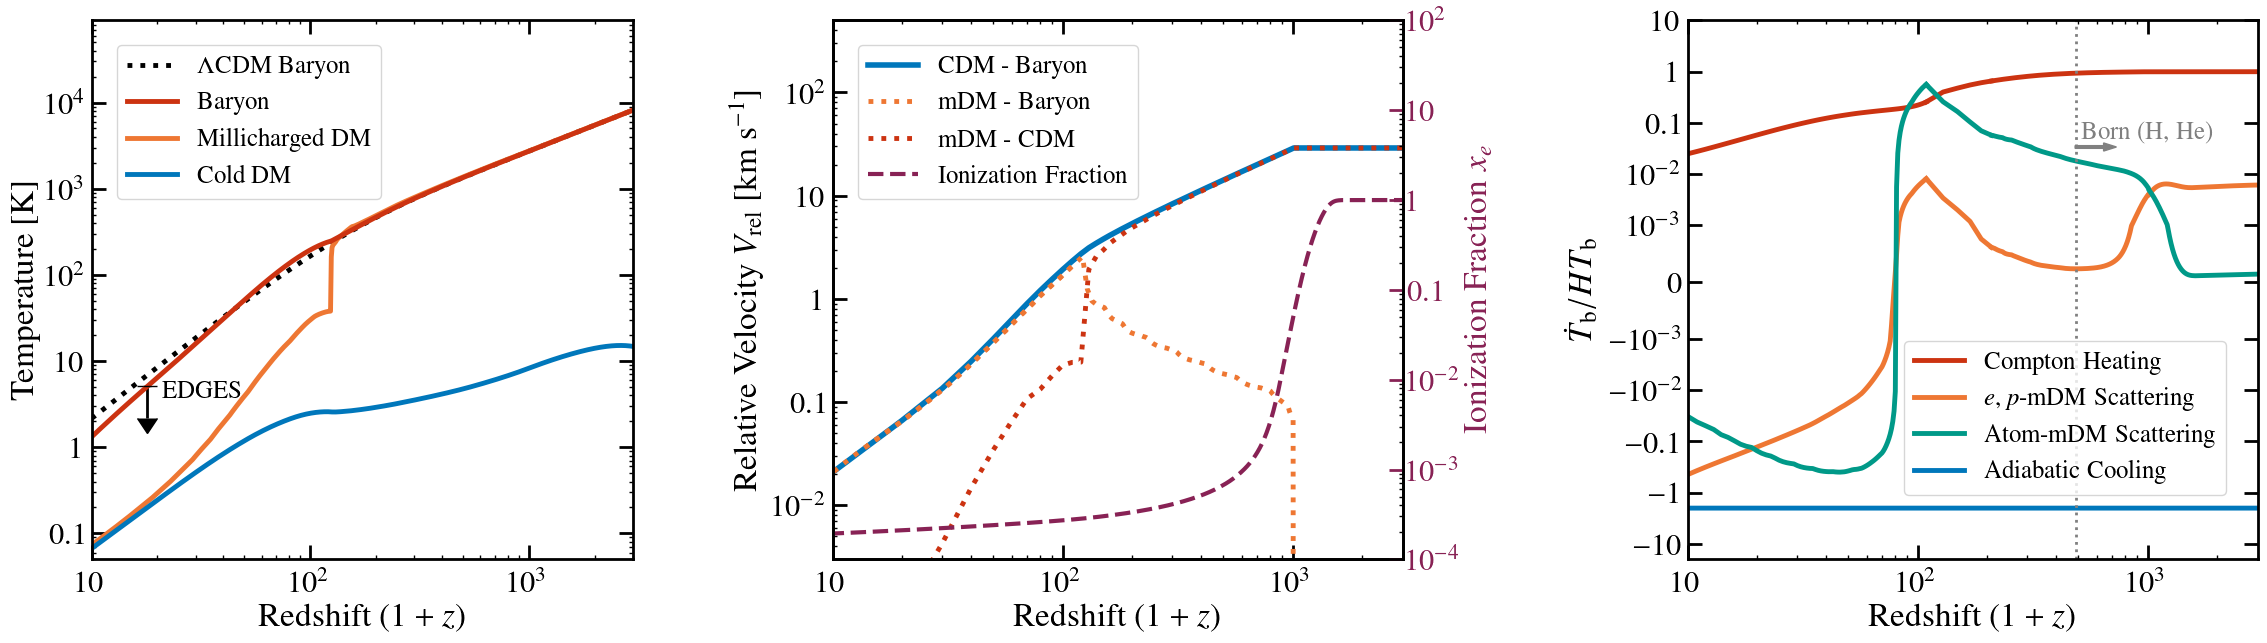

In [10]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

from matplotlib import rcParams

# pal = ['#332288', '#88CCEE', '#44AA99', '#117733', '#999933', '#DDCC77', '#CC6677', '#882255', '#AA4499']
# pal = ['#77aadd', '#99ddff', '#44bb99', '#bbcc33', '#aaaa00', '#eedd88', '#ee8866', '#ffaabb', '#dddddd']

pal = ['#CC3311', '#EE7733', '#0077BB', '#009988', '#882255', '#EE3377']


rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = '\\usepackage{txfonts}'


fig = plt.figure(figsize=(19*3/2, 7), constrained_layout=False)

gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.24)
ax1 = fig.add_subplot(gs1[0, 0])

gs2 = fig.add_gridspec(nrows=1, ncols=2, left=0.31, right=0.81, wspace=0.5)
ax2 = fig.add_subplot(gs2[0, 0])
ax4 = fig.add_subplot(gs2[0, 1])

Q_str      = r'$10^{-2}$'
alpha_eff_str    = r'$4 \times 10^{-15}$'

ax1.loglog()

EDGES = ax1.errorbar([18], [5.2], fmt="_", capsize=7, yerr=3, uplims=True, color='k', linewidth=2, label=r'$T_m(z = 17)$ = 5.2 K')

T_std_plt,  = ax1.plot(np.arange(10, 3000), std_Tm(np.arange(10, 3000))/phys.kB, 'k:', label=r'$\Lambda$CDM Baryon')
T_chi_plt,  = ax1.plot(rs_vec, T_m_arr/phys.kB, color=pal[1], label=r'Millicharged DM')
T_zeta_plt, = ax1.plot(rs_vec, T_C_arr/phys.kB, color=pal[2], label=r'Cold DM')
T_IGM_plt,  = ax1.plot(rs_vec, T_b_arr/phys.kB, color=pal[0], label=r'Baryon')

ax1.set_xlim([10, 3000])
ax1.set_ylim([5e-2, 9e4])
ax1.set_xlabel(r'Redshift $(1+z)$')
ax1.set_ylabel(r'Temperature [K]')


ax1.text(0.13, 0.3, 'EDGES', transform=ax1.transAxes, fontsize=18)

ax1.legend(handles = [T_std_plt, T_IGM_plt, T_chi_plt, T_zeta_plt], loc='upper left')

ax2.loglog()

V_zeta_b_plt, = ax2.plot(rs_vec[::10], (V_mC_arr[::10] + V_bm_arr[::10]) * phys.c * 1e-5, color=pal[2], linewidth=4, label='CDM - Baryon')
V_chi_zeta_plt, = ax2.plot(rs_vec[::10], V_mC_arr[::10] * phys.c * 1e-5, color=pal[0], label=r'mDM - CDM', linestyle=':')
V_chi_b_plt, = ax2.plot(rs_vec[::6], V_bm_arr[::6] * phys.c * 1e-5, color=pal[1], label='mDM - Baryon', linestyle=':')
V_chi_b_plt_2, = ax2.plot(rs_vec[-100:], V_bm_arr[-100:] * phys.c * 1e-5, color=pal[1], linestyle=':')

ax2.set_xlim([10, 3000])
ax2.set_ylim([3e-3, 5e2])

ax2.set_xlabel(r'Redshift $(1+z)$')
ax2.set_ylabel(r'Relative Velocity $V_\mathrm{rel}$ [km s$^{-1}$]')

ax3 = ax2.twinx()
ax3.loglog()

xe_plt,      = ax3.plot(
    rs_vec, xe_arr, 
    color=pal[4], linestyle='--', linewidth=3, label='Ionization Fraction'
)

ax2.legend(handles = [V_zeta_b_plt, V_chi_b_plt, V_chi_zeta_plt, xe_plt], loc='upper left')


ax3.set_xlim([10, 3000])
ax3.set_ylim([1e-4, 1e2])

ax3.set_ylabel(r'Ionization Fraction $x_e$', color=pal[4])
ax3.yaxis.label.set_color(pal[4])
ax3.tick_params(axis='y', colors=pal[4])


ax4.set_xscale('log')
ax4.set_yscale('symlog', linthreshy=1e-3)

ep_cooling_rate_pos = np.zeros_like(ep_cooling_rate)
ep_cooling_rate_neg = np.zeros_like(ep_cooling_rate)
HHe_cooling_rate_pos = np.zeros_like(HHe_cooling_rate)
HHe_cooling_rate_neg = np.zeros_like(HHe_cooling_rate)

ep_cooling_rate_pos[ep_cooling_rate > 0]    = ep_cooling_rate[ep_cooling_rate > 0]
ep_cooling_rate_neg[ep_cooling_rate <= 0]   = ep_cooling_rate[ep_cooling_rate <= 0]
HHe_cooling_rate_pos[HHe_cooling_rate > 0]  = HHe_cooling_rate[HHe_cooling_rate > 0]
HHe_cooling_rate_neg[HHe_cooling_rate <= 0] = HHe_cooling_rate[HHe_cooling_rate <= 0]

compton_plt_1, = ax4.plot(rs_vec[:-200], compton_cooling_rate[:-200], color=pal[0], label=r'Compton Heating')
compton_plt_2, = ax4.plot(rs_vec[-200:-80:20], compton_cooling_rate[-200:-80:20], color=pal[0], label=r'Compton Heating')
compton_plt_3, = ax4.plot(rs_vec[-100:], compton_cooling_rate[-100:], color=pal[0], label=r'Compton Heating')
ep_plt,        = ax4.plot(rs_vec[:-200], ep_cooling_rate[:-200], color=pal[1], label=r'$e,p$-mDM Scattering')
HHe_plt,       = ax4.plot(rs_vec[:-200], HHe_cooling_rate[:-200], color=pal[3], label=r'Atom-mDM Scattering')
ep_plt_2,      = ax4.plot(rs_vec[-200:-80:20], ep_cooling_rate[-200:-80:20], color=pal[1], label=r'$e,p$-mDM Scattering')
HHe_plt_2,     = ax4.plot(rs_vec[-200:-80:20], HHe_cooling_rate[-200:-80:20], color=pal[3], label=r'Atom-mDM Scattering')
ep_plt_3,      = ax4.plot(rs_vec[-100:], ep_cooling_rate[-100:], color=pal[1], label=r'$e,p$-mDM Scattering')
HHe_plt_3,     = ax4.plot(rs_vec[-100:], HHe_cooling_rate[-100:], color=pal[3], label=r'Atom-mDM Scattering')
adiab_plt,     = ax4.plot(rs_vec, -2.*np.ones_like(rs_vec), color=pal[2], label='Adiabatic Cooling')

ax4.set_xlabel(r'Redshift $(1+z)$')
ax4.set_ylabel(r'$\dot{T}_\mathrm{b}/ H T_\mathrm{b}$')

ax4.set_xlim([10, 3000])
ax4.set_ylim([-20, 10])

ax4.axvline(rs_born_break, color='gray', linestyle=':', linewidth=2)

ax4.arrow(0.68, 0.765, 0.05, 0, transform=ax4.transAxes, color='gray', width=.005)
ax4.text(0.69, 0.78, 'Born (H, He)', transform=ax4.transAxes, fontsize=18, color='gray')






ax4.legend(handles = [compton_plt_1, ep_plt, HHe_plt, adiab_plt], loc=(.38, .12))


# plt.tight_layout()
# plt.subplots_adjust(wspace=.5)

# plt.savefig('/Users/hongwan/Dropbox (MIT)/Millicharged_Hydrogen/Draft/figures/temperature_ev_Vrel.pdf', bbox_inches='tight')
